- Кластеризация по расстоянию
- Колиниарность признаков

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt

In [3]:
df = pd.read_csv("california_housing_train.csv")
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           17000 non-null  float64
 1   latitude            17000 non-null  float64
 2   housing_median_age  17000 non-null  float64
 3   total_rooms         17000 non-null  float64
 4   total_bedrooms      17000 non-null  float64
 5   population          17000 non-null  float64
 6   households          17000 non-null  float64
 7   median_income       17000 non-null  float64
 8   median_house_value  17000 non-null  float64
dtypes: float64(9)
memory usage: 1.2 MB


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000
mean,-119.562108,35.625225,28.589353,2643.664412,539.410824,1429.573941,501.221941,3.883578,207300.912353
std,2.005166,2.137340,12.586937,2179.947071,421.499452,1147.852959,384.520841,1.908157,115983.764387
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.790000,33.930000,18.000000,1462.000000,297.000000,790.000000,282.000000,2.566375,119400.000000
50%,-118.490000,34.250000,29.000000,2127.000000,434.000000,1167.000000,409.000000,3.544600,180400.000000
75%,-118.000000,37.720000,37.000000,3151.250000,648.250000,1721.000000,605.250000,4.767000,265000.000000
max,-114.310000,41.950000,52.000000,37937.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


## Visualization

array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

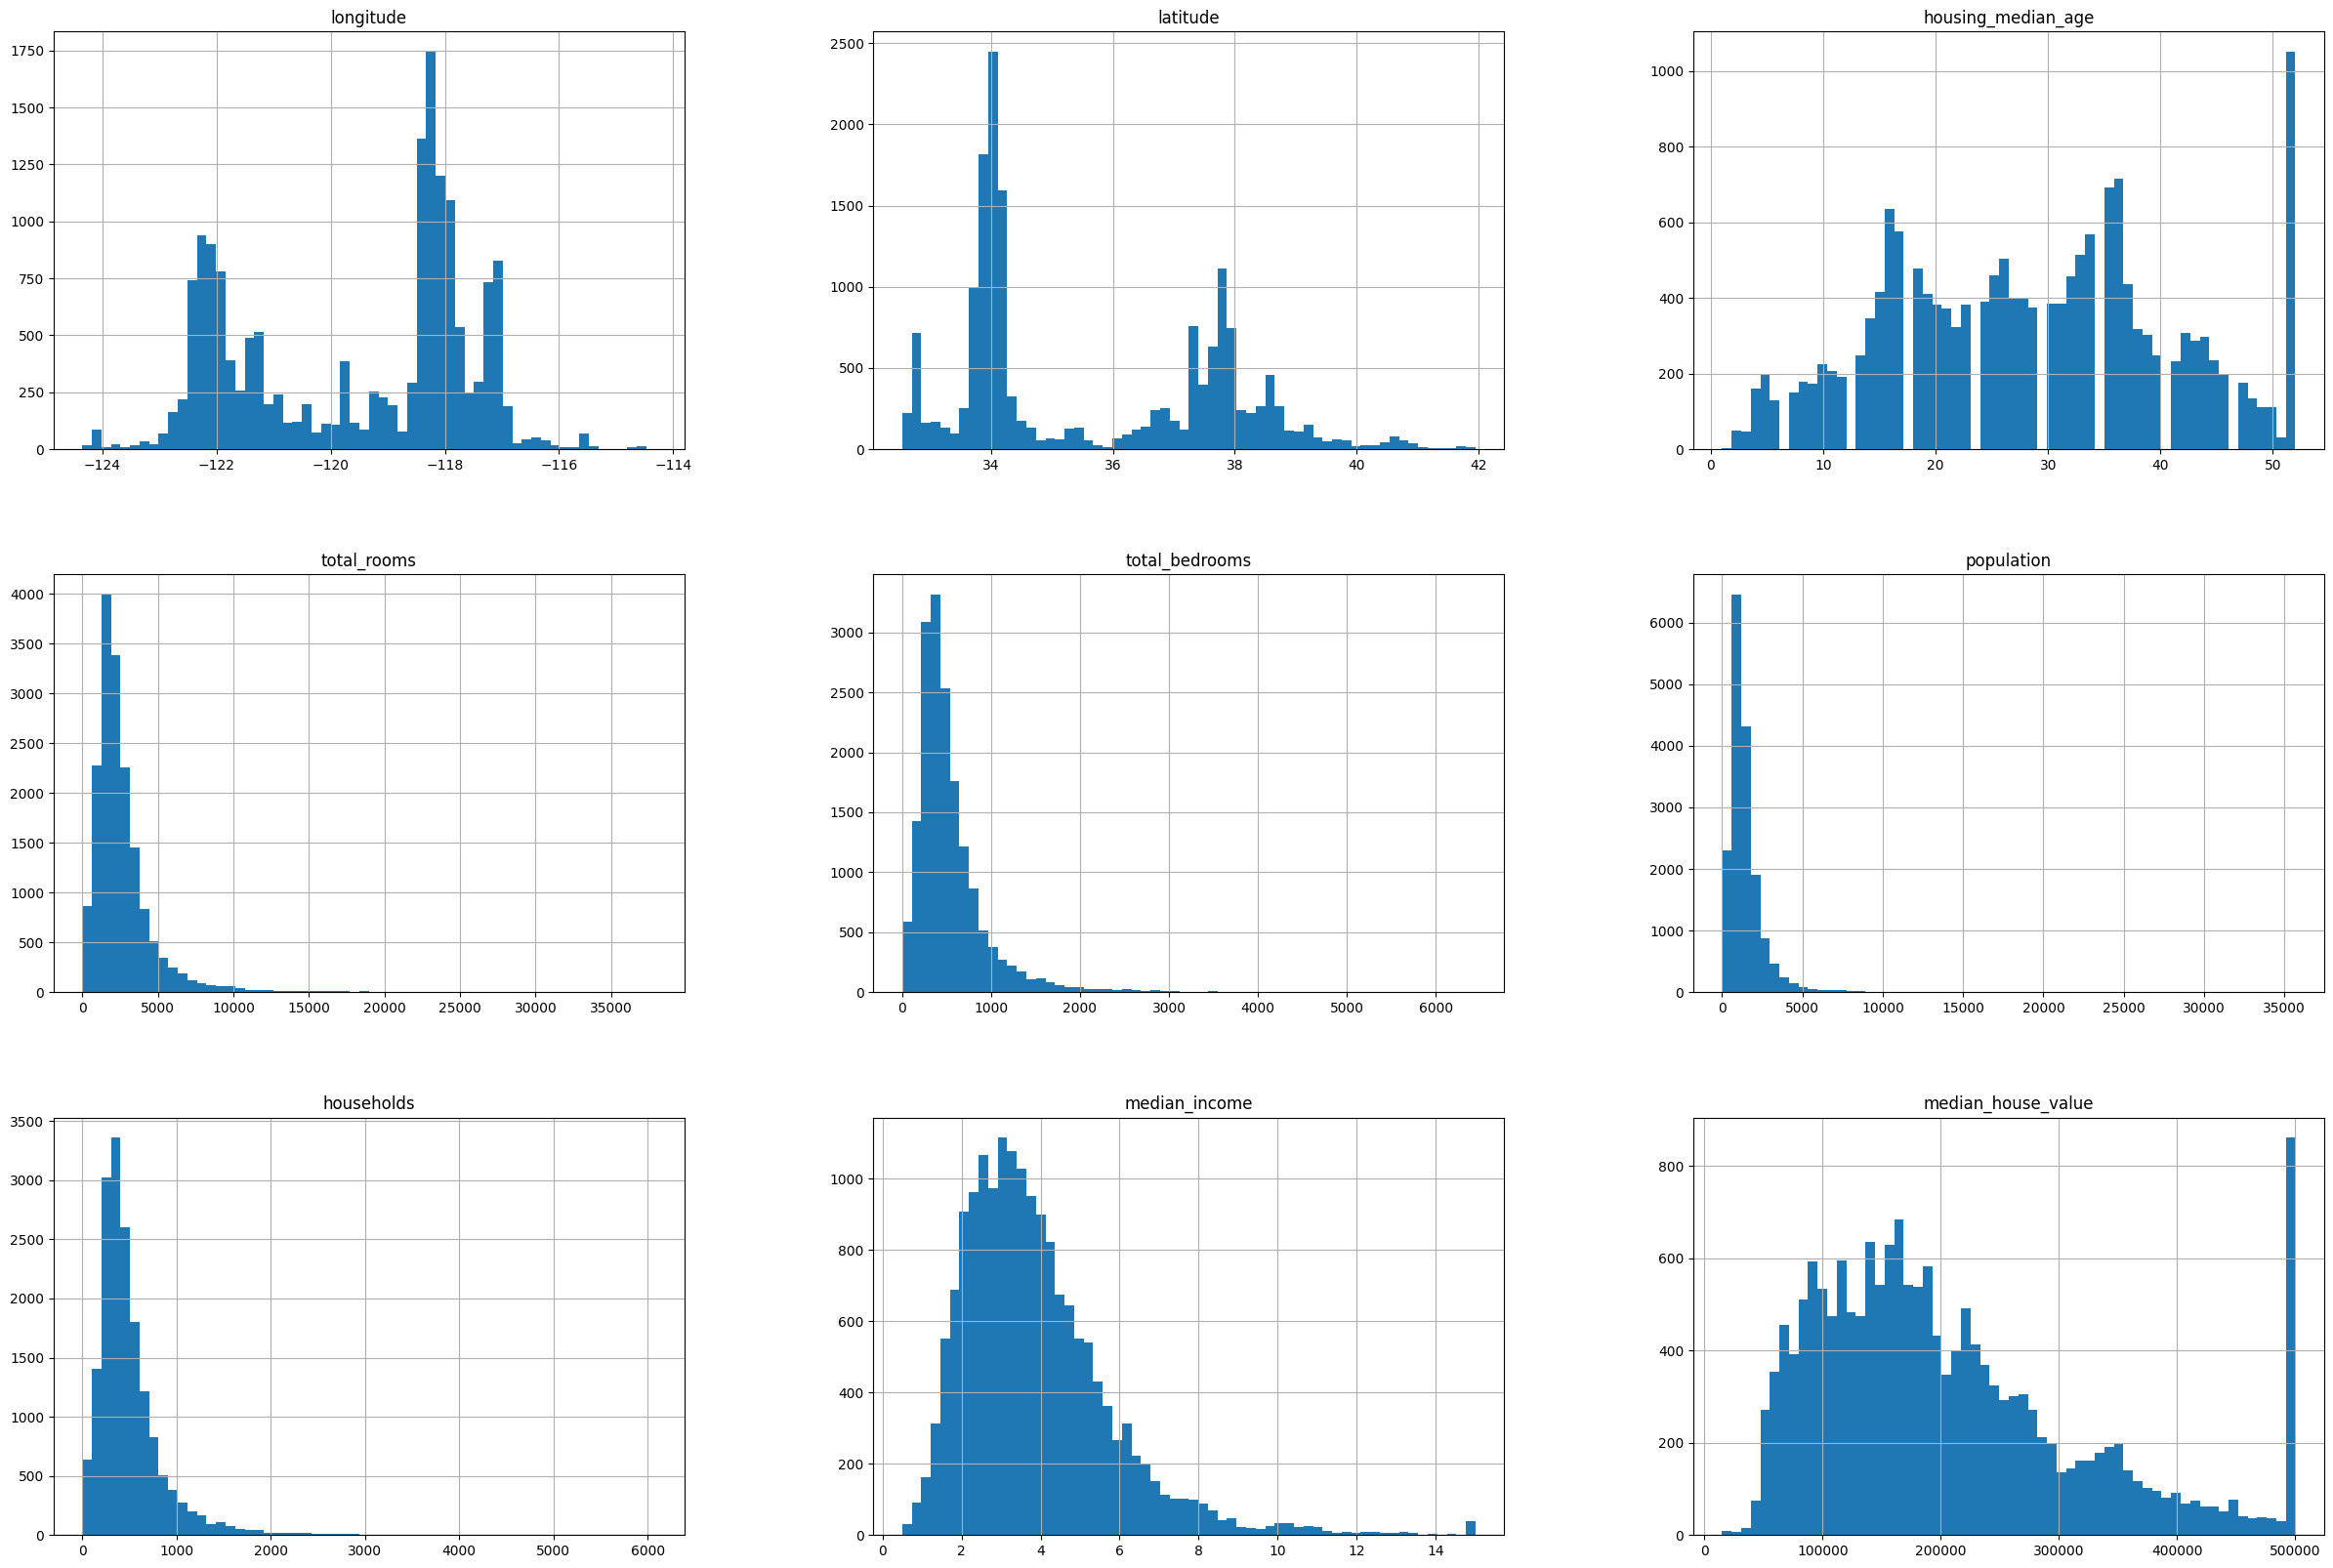

In [54]:
df.hist(bins=60, figsize=(30, 20))

Для более удобной работы с доходом, разделим доход на несколько категории

<Axes: xlabel='median_income_cat'>

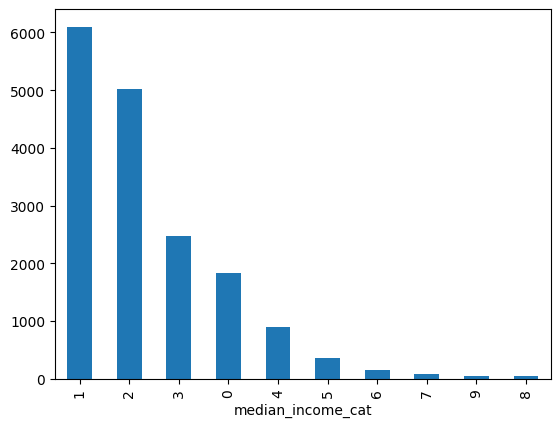

In [55]:
#df['median_income_cat'] = pd.cut(df['median_income'], [0, 1.5, 2, 4, 6, 8, 9, np.inf], labels=range(1, 8))
df['median_income_cat'] = pd.cut(df['median_income'], 10, labels=range(10))
df['median_income_cat'].value_counts().plot(kind='bar')

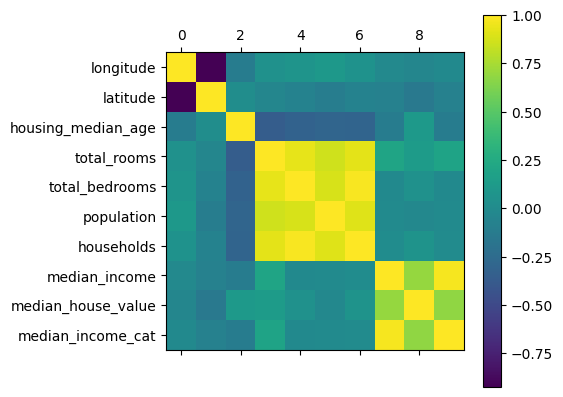

In [56]:
plt.matshow(df.corr())
plt.yticks(range(len(df.columns)), df.columns)
plt.colorbar()

0.9809200924180902


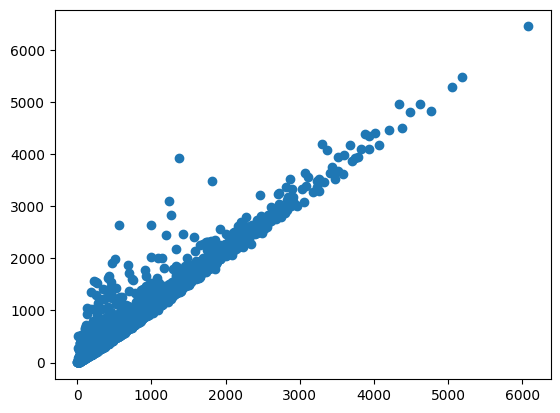

In [6]:
plt.scatter(df['households'], df['total_bedrooms'])
print(df.corr()['households']['total_bedrooms'])
df.drop('total_bedrooms', axis=1, inplace=True)

Можем заметить корреляцию между доходом и ценой, давайте поподробнее рассмотрим этот признак.

C:\Users\dmitr\AppData\Local\Temp\ipykernel_12100\4246714058.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('median_income_cat')['median_house_value'].mean().plot(kind='bar')


<Axes: xlabel='median_income_cat'>

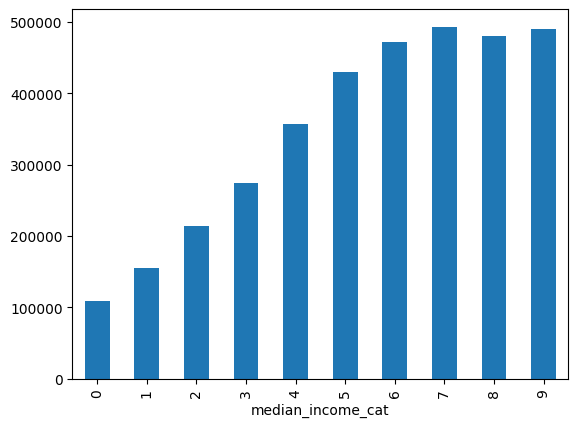

In [57]:
df.groupby('median_income_cat')['median_house_value'].mean().plot(kind='bar')

Есть не совсем линейная корреляция между двумя признаками, теперь проверим разброс признака.

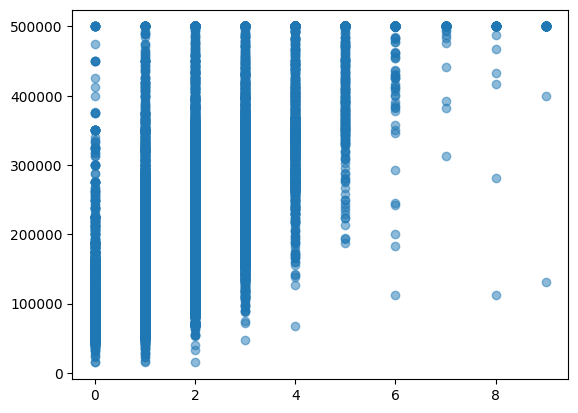

In [58]:
plt.scatter(df['median_income_cat'], df['median_house_value'], alpha=0.5)

Разброс не совсем равномерный, низко-средний доход живет в домах всех цен. А чем больше доход, тем меньше диапозон цены. Теперь можем ещё рассмотреть как гео-расположение влияет на стоимость.

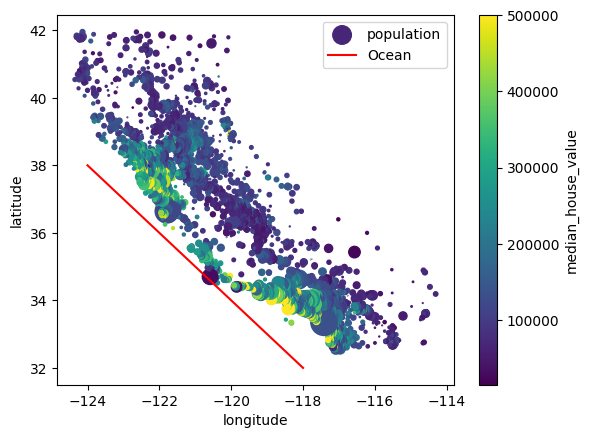

In [59]:
df.plot(
    kind='scatter',
    x='longitude',
    y='latitude',
    s=df.population/100,
    label="population",
    c="median_house_value",
    colorbar=True
)

plt.plot([-124, -118], [38, 32], c='red', label='Ocean')
plt.legend()

Стоит заметить, по распределению точек, действительно похоже на штат калифорния. И чем ближе к океану, тем выше цена. Поэтому стоит ещё сделать один признак "близость к берегу". Берег изображен в графике красной линии, и после небольшого расчёта, было получено уравнение для этой линии: `-6x - 6y - 516 = 0`

In [60]:
A = -6
B = -6
C = -516

df['distance_to_ocean'] = abs(df['longitude'] * A + df['latitude'] * B + C) / sqrt(A*A + B*B)
print(df['distance_to_ocean'].head())

0    4.157788
1    4.193143
2    3.627458
3    3.585031
4    3.535534
Name: distance_to_ocean, dtype: float64


И теперь проверим нашу гепотизу...

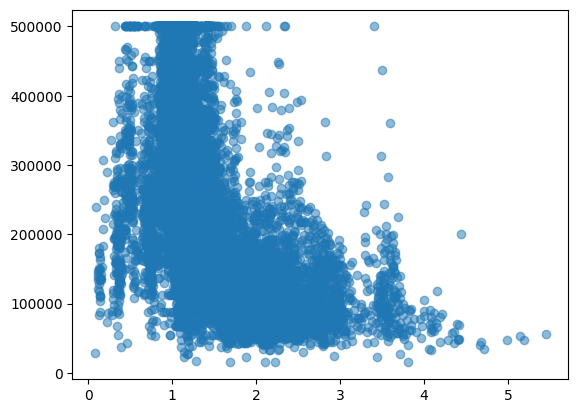

In [67]:
plt.scatter(df['distance_to_ocean'], df['median_house_value'], alpha=0.5)

## Train-Test split

In [7]:
train_percent = 0.6
random_state = 336771

train = df.sample(frac=train_percent, random_state=random_state)
test = df.drop(train.index)
train_x = train.drop('median_house_value', axis=1)
train_y = train['median_house_value']
test_x = test.drop('median_house_value', axis=1)
test_y = test['median_house_value']

## Least-Square Method

In [8]:
class LSM:
    def __init__(self, col_names: list[str]):
        self.col_names = col_names
    
    @staticmethod
    def _prepend_ones(x):
        return np.concatenate((np.ones((len(x), 1)), x), axis=1)

    @staticmethod
    def sum_of_squares(true_y, pred_y):
        return np.sum(np.square(true_y - pred_y))

    @staticmethod
    def determination_coefficient(true_y, pred_y):
        mean_y = np.mean(true_y)
        rss = np.sum(np.square(true_y - pred_y))
        tss = np.sum(np.square(true_y - mean_y))

        return 1 - rss / tss

    def train(self, x: pd.DataFrame, y: pd.Series):
        x = LSM._prepend_ones(np.array(x[self.col_names]))
        y = np.array(y)
        self.b = np.linalg.inv((x.T @ x)) @ x.T @ y

    def pred(self, x: pd.DataFrame) -> list[float]:
        return np.array(LSM._prepend_ones(x[self.col_names])) @ self.b.T

## Модель по всем признакам

In [9]:
lsm = LSM(train_x.columns)
lsm.train(train_x, train_y)
pred_y = lsm.pred(test_x)
print('Коэффициент детерминации:', LSM.determination_coefficient(test_y, pred_y))
print('Сумма квадратов:', LSM.sum_of_squares(test_y, pred_y))

Коэффициент детерминации: 0.6370233753802913
Сумма квадратов: 32270843404539.11


## Модель по median_income

In [64]:
lsm = LSM(['median_income'])
lsm.train(train_x, train_y)
pred_y = lsm.pred(test_x)
print('Коэффициент детерминации:', LSM.determination_coefficient(test_y, pred_y))
print('Сумма квадратов:', LSM.sum_of_squares(test_y, pred_y))

Коэффициент детерминации: 0.479724916737689
Сумма квадратов: 46255639069959.95


## Модель по median_income, total_rooms, distance_to_ocean

In [10]:
lsm = LSM(['median_income', 'total_rooms', 'distance_to_ocean'])
lsm.train(train_x, train_y)
pred_y = lsm.pred(test_x)
print('Коэффициент детерминации:', LSM.determination_coefficient(test_y, pred_y))
print('Сумма квадратов:', LSM.sum_of_squares(test_y, pred_y))

KeyError: "['distance_to_ocean'] not in index"

Можем сделать вывод, что в калифорнии цена дома наиболее сильно зависит от дохода и близости к океану. Если хотите дешево жить, то нужно переезжать в гетто и подальше от океана.